In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Least Squares Regression with Gradient Boosting

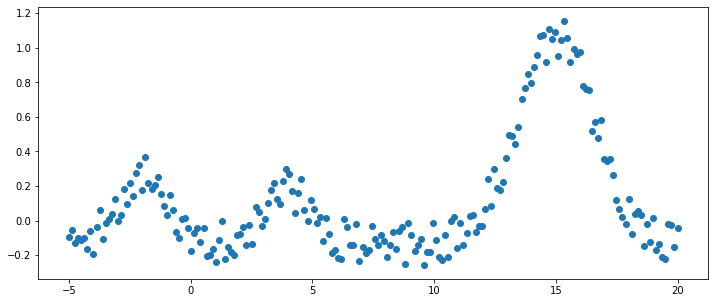

In [2]:
x = np.linspace(-5,20, 200)
data_x = x 
data_y = 1/np.sqrt(2*np.pi) * np. exp( -(x+2)**2 / (2) ) +\
         1/np.sqrt(2*np.pi) * np. exp( -(x-4)**2 / (2) ) *0.8 +\
         1/np.sqrt(2*np.pi) * np. exp( -(x-15)**2 / (5) ) * 3
data_y -= np.mean(data_y)

data_y += np.random.rand(200)/4

plt.figure(figsize=(12,5))
plt.scatter(data_x, data_y);

## 1. fit a regressor with high bias

We choose a shallow decision tree regressor

In [0]:
from sklearn.tree import DecisionTreeRegressor

def weak_learner(data, target, max_depth=1):
    tree = DecisionTreeRegressor(criterion='mse', max_depth=max_depth)
    tree.fit(data[:,None], target)
    pred = tree.predict(data[:,None]);
    return pred

### Compute residuals

### $r_{im} = \frac{\partial}{\partial F(x_i)} L(F(x_i), y_i) = y_i - F(x_i)\text{, for } i = 1,...,n.$

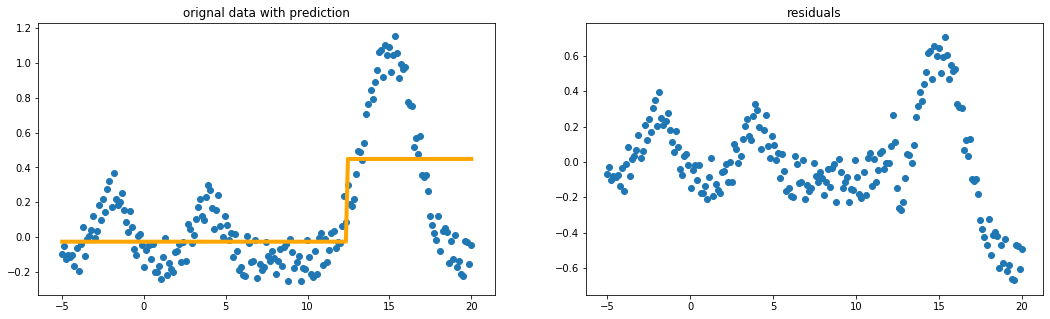

In [4]:
pred_y = []
pred_y.append( weak_learner(data_x, data_y) )

plt.figure(figsize=(18,5))
plt.subplot(121); plt.plot(data_x, pred_y[-1], color='orange', linewidth=4);
plt.scatter(data_x, data_y); plt.title("orignal data with prediction"); ylim = plt.ylim();

residuals = data_y - pred_y[-1]
plt.subplot(122); plt.scatter(data_x, residuals); plt.title("residuals");

## 2. fit next regressor to the residuals

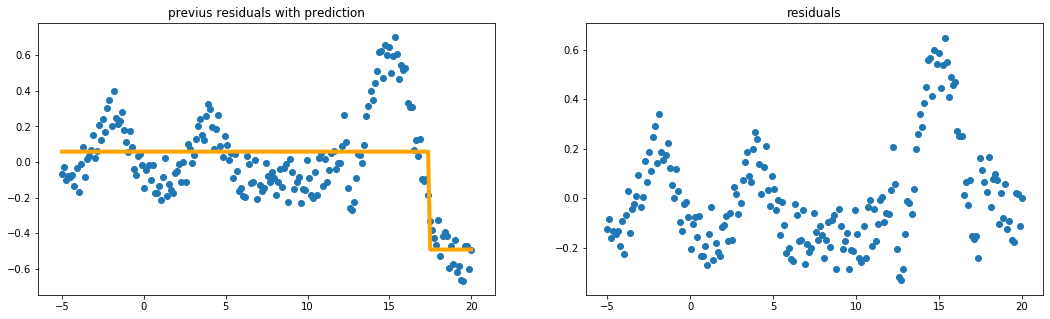

In [5]:
pred_y.append( weak_learner(data_x, residuals) )

plt.figure(figsize=(18,5))
plt.subplot(121); plt.plot(data_x, pred_y[-1], color='orange', linewidth=4);
plt.scatter(data_x, residuals); plt.title("previus residuals with prediction");

residuals = residuals - pred_y[-1]
plt.subplot(122); plt.scatter(data_x, residuals); plt.title("residuals");

**To simplify, we omit choosing weight for the classifier!**

## 3. repeat M times

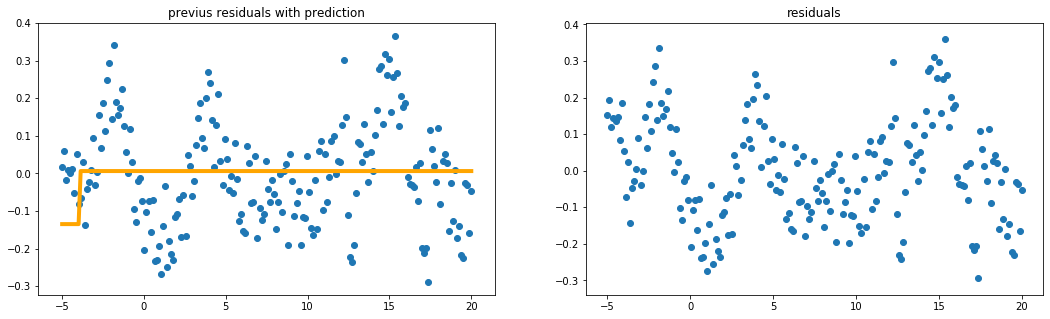

In [6]:
for i in range(5):
    pred_y.append( weak_learner(data_x, residuals) )
    residuals = residuals - pred_y[-1]

plt.figure(figsize=(18,5))
plt.subplot(121); plt.plot(data_x, pred_y[-1], color='orange', linewidth=4);
plt.scatter(data_x, residuals); plt.title("previus residuals with prediction");

residuals = residuals - pred_y[-1]
plt.subplot(122); plt.scatter(data_x, residuals); plt.title("residuals");

We see that residuals become more and more noisy, when there's no information except this noise, overfitting will begin!

## 4. connect regressors

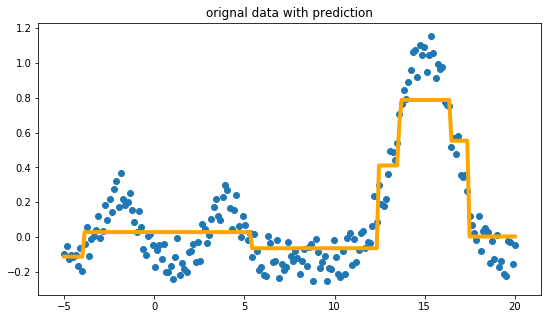

In [7]:
connected_predicitons = np.array(pred_y).sum(0)

plt.figure(figsize=(9,5))
plt.plot(data_x, connected_predicitons, color='orange', linewidth=4);
plt.scatter(data_x, data_y); plt.title("orignal data with prediction"); plt.ylim(ylim);

## Interactive visualization

In [0]:
def draw(M, learning_rate=1.0, tree_depth=1):
    pred_y = []
    for i in range(M):
        #if len(pred_y) < M:
        residuals = data_y - np.array(pred_y).sum(0)
        pred_y.append( weak_learner(data_x, residuals * learning_rate, max_depth = tree_depth) )
        
    connected_predicitons = np.array(pred_y[:M]).sum(0)
    plt.figure(figsize=(12,5))
    plt.plot(data_x, connected_predicitons, color='orange', linewidth=4);
    plt.scatter(data_x, data_y); plt.title("M value: " + str(M)); plt.ylim(ylim);

In [27]:
interactive_plot = interactive( draw,
                M=widgets.IntSlider(min=1,max=200,step=1,value=1, continuous_update=False),
                learning_rate=widgets.FloatText(step=0.1,value=1,continuous_update=True),
                tree_depth=widgets.IntText(step=1,value=1, continuous_update=True))

output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=1, continuous_update=False, description='M', max=200, min=1), FloatText(…

# Binary Classification with Gradient Boosting

## Loading explanatory data

training shape:  (400, 30)
test set shape:  (169, 30)


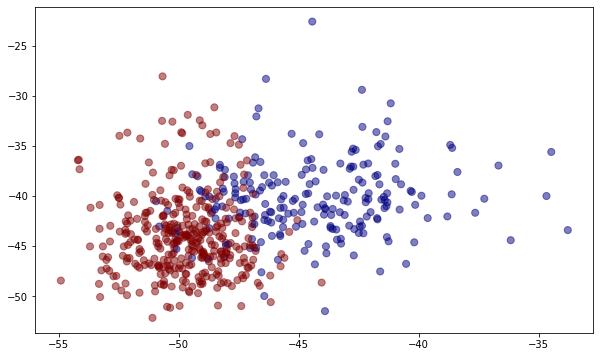

In [10]:
from sklearn import datasets
dataset = datasets.load_breast_cancer()

data = dataset['data']
data -= np.mean(data)

targ = dataset['target']

train_x = data[:400]
train_y = targ[:400]
test_x = data[400:]
test_y = targ[400:]

print('training shape: ', train_x.shape)
print('test set shape: ', test_x.shape)

plt.figure(figsize=(10,6))
plt.scatter(data[:, 0], data[:, 1], c=targ, alpha=0.5, cmap='jet', s=50);

## We will treat classification similarly as regression

**We round predicted float value to the closest integer**

In [0]:
from sklearn.tree import DecisionTreeRegressor

def weak_classify(data, target):
    tree = DecisionTreeRegressor(criterion='mse', max_depth=1)
    tree.fit(data, target)
    pred = tree.predict(data);
    return pred, tree

def predict(trees, data, learning_rate=1):
    pred = trees[0].predict(test_x)
    for tree in trees[1:]:
        pred += tree.predict(test_x) * learning_rate
    return np.round( pred )

## Create first learner

In [12]:
prediction = []
trees = []
tr_errors = []
ts_errors = []

pred, tree = weak_classify(train_x, train_y)
prediction.append(pred)
trees.append(tree)

resi = train_y - prediction[-1]

tr_errors.append( np.sum( np.round(np.array(prediction).sum(0)) == train_y) / train_y.shape[0] )
ts_errors.append( np.sum(predict(trees, test_x) == test_y)/test_y.shape[0] )
print( 'training accuracy: ', tr_errors[-1] )
print( 'test accuracy: ', ts_errors[-1] )

training accuracy:  0.925
test accuracy:  0.893491124260355


# Create next M learners

**The same way as before - fit the next learner to the residuals of the previous one!**

In [13]:
learning_rate = 0.5

for i in range(100): # M = 100 here
    pred, tree = weak_classify(train_x, resi)
    prediction.append(pred * learning_rate)
    trees.append(tree)
    
    resi =  (resi - prediction[-1]) # calculate new residuals
    
    # save errors to history array
    tr_errors.append( np.sum(np.round( np.array(prediction).sum(0) ) == train_y) / train_y.shape[0] )
    ts_errors.append( np.sum(predict(trees, test_x) == test_y)/test_y.shape[0] )
    
print( 'training error: ', np.max(np.array(tr_errors)) )
print( 'test error: ', np.max(np.array(ts_errors)) )

training error:  0.9825
test error:  0.9644970414201184


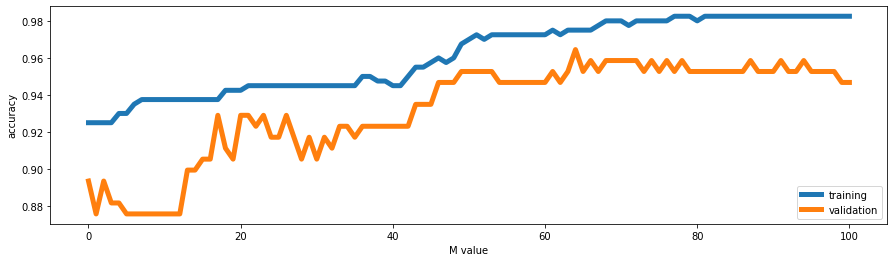

In [14]:
plt.figure(figsize=(15,4))
plt.plot(tr_errors, linewidth=5, label='training')
plt.plot(ts_errors, linewidth=5, label='validation')
plt.xlabel('M value')
plt.ylabel('accuracy')
plt.legend(loc=4)

### It can be compared with Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier as RFC
forest = RFC(n_estimators=100)
forest.fit(train_x, train_y)
forest.score(test_x, test_y)

0.9763313609467456

# Binary Classification with Adaptive Boosting

## 0) We introduce a probability distribution

In [16]:
distrib = np.ones(train_x.shape[0]) / train_x.shape[0]
print("Probability distribution:", distrib[:10], "...")

idx = np.random.choice(range(train_x.shape[0]), size=train_x.shape[0], replace=True, p=distrib)
idx = np.unique(idx)

temporal_train_x = train_x [ idx ]
temporal_train_y = train_y [ idx ]

print("Uniques in sampled set:", idx.shape[0])

Probability distribution: [0.0025 0.0025 0.0025 0.0025 0.0025 0.0025 0.0025 0.0025 0.0025 0.0025] ...
Uniques in sampled set: 250


## 1) Create first classifier on it
**Decision Tree stomp**

In [17]:
pred, tree = weak_classify(temporal_train_x, temporal_train_y)
pred = np.round(tree.predict(train_x)) 
accuracy = np.sum(pred==train_y) / pred.shape[0]

print( 'training accuracy: ', accuracy )
print( 'test accuracy: ', np.sum( np.round(tree.predict(test_x)) == test_y) / test_y.shape[0] )

training accuracy:  0.9125
test accuracy:  0.893491124260355


## 2) Compute classifier weight

### $\alpha_t = \frac12 \ln(\frac{1-\epsilon_t}{\epsilon_t})$

In [18]:
def classifier_weight(accuracy):
    return 1/2 * np.log((accuracy)/(1-accuracy))

weight = classifier_weight(accuracy)
print(weight)

1.1722746460465387


## 3) Compute new data distribution

### $D_{t+1}(i) = \frac{D_{t} \exp(-\alpha_t y_i h_t (x_i)) }{Z_t}$

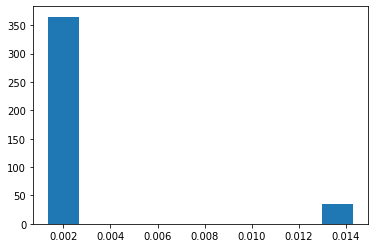

In [19]:
YtimesH = np.array([-1,1])[(pred == train_y)*1] # swap from [0,1] to [-1,1]!
distrib = distrib * np.exp( -weight * YtimesH )
distrib /= np.sum(distrib)

plt.hist(distrib);

## 4) Sample training dataset

In [20]:
idx = np.random.choice(range(train_x.shape[0]), size=train_x.shape[0], replace=True, p=distrib)
idx = np.unique(idx)

temporal_train_x = train_x [ idx ]
temporal_train_y = train_y [ idx ]

print("Uniques in sampled set:", idx.shape[0])

Uniques in sampled set: 185


## 5) Repeat!

In [0]:
def AdaBoost_step(forest, weights, distribution):

    # Sample from distribution
    idx = np.random.choice(range(train_x.shape[0]),
                           size=int(train_x.shape[0]/6), replace=False, p=distribution)
 
    # A little tweak - add some easy examples to stabilize the training
    idx2 = np.random.choice(range(train_x.shape[0]), size=int(train_x.shape[0]/6),
                            replace=False, p=(1/distribution)/np.sum(1/distribution))
    idx = np.append(idx, idx2)
    idx = np.unique(idx)
    
    temporal_train_x = train_x [ idx ]
    temporal_train_y = train_y [ idx ]
    
    # Classify with new classifier
    pred, tree = weak_classify(temporal_train_x, temporal_train_y)
    forest.append(tree)
    
    pred = np.round(tree.predict(train_x))
    accuracy = np.sum(pred==train_y) / pred.shape[0]    

    # Compute classifier weight
    weight = classifier_weight(accuracy)
    weights.append(weight)
    
    train_acc = np.sum(forest_predict(forest, weights, train_x)==train_y)/train_y.shape[0]
    test_acc = np.sum(forest_predict(forest, weights, test_x)==test_y)/test_y.shape[0]
    
    # Compute data distribution
    YtimesH = np.array([-1,1])[(pred == train_y)*1]
    distribution = distribution * np.exp( -weight * YtimesH )
    distribution /= np.sum(distribution)
    
    return forest, weights, distribution, train_acc, test_acc

In [0]:
def forest_predict(forest, weights, data):
    prediction = np.zeros(data.shape[0])
    #weights = np.array(weights) / sum(weights)
    
    for tree, weight in zip(forest, weights):
        prediction += (tree.predict(data) * 2 - 1) * weight
    
    return (prediction>=0)*1

### we reset the distribution

In [0]:
forest = []
weights = []
tr_acc = []
ts_acc = []
distribution = distribution = np.ones(train_x.shape[0]) / train_x.shape[0]

### and make M iterations

In [24]:
for i in range(200):
    forest, weights, distribution, acc, ts = AdaBoost_step(forest, weights, distribution)
    tr_acc.append(acc)
    ts_acc.append(ts)
    
print('training accuracy:', max(tr_acc))
print('test accuracy:', max(ts_acc))

training accuracy: 0.985
test accuracy: 0.9704142011834319


### and plot the training curves

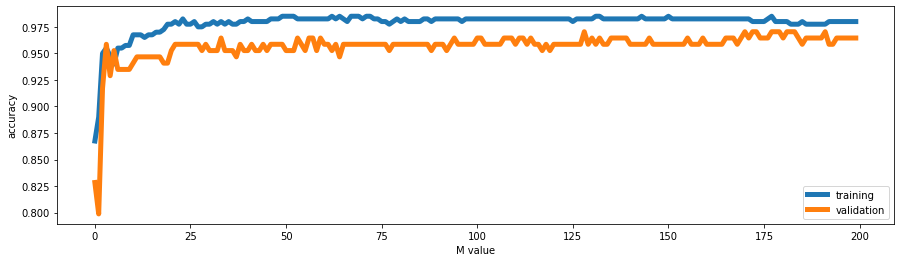

In [25]:
plt.figure(figsize=(15,4))
plt.plot(tr_acc, linewidth=5, label='training')
plt.plot(ts_acc, linewidth=5, label='validation')
plt.xlabel('M value')
plt.ylabel('accuracy')
plt.legend(loc=4)

### It can be compared with stable, sklearn AdaBoost

In [26]:
from sklearn.ensemble import AdaBoostClassifier as ABC
forest = ABC(n_estimators=1000)
forest.fit(train_x, train_y)
forest.score(test_x, test_y)

0.9822485207100592